# Sentiment analysis

### What is sentiment analysis?

In this notebook, we're going to perform [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) on a dataset of tweets about US airlines. Sentiment analysis is the task of extracting [affective states][1] from text. Sentiment analysis is most ofen used to answer questions like:

[1]: https://en.wikipedia.org/wiki/Affect_(psychology)

- _is this tweet positive or negative?_
- _what do our customers think of us?_
- _do our users like the look of our product?_
- _what aspects of our service are users dissatisfied with?_

### Sentiment analysis as text classification

We're going to treat sentiment analysis as a text classification problem. Text classification is just like other instances of classification in data science. We use the term "text classification" when the features come from natural language data. (You'll also hear it called "document classification" at times.) What makes text classification interestingly different from other instances of classification is the way we extract numerical features from text. 

### Dataset

The dataset was collected by [Crowdflower](https://www.crowdflower.com/), which they then made public through [Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment). I've downloaded it for you and put it in the "data" directory.

### Tasks

I've already read in the data into two lists, `tweets` and `sentiments`.

You'll need to:
- Preprocess the dataset
- Perform classification

In [89]:
%matplotlib inline
import os
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from string import punctuation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
sns.set()

DATA_DIR = '../data'

## Read in the dataset

In [90]:
def read_airline_tweets():
    fname = os.path.join(DATA_DIR, 'tweets.csv')
    df = pd.read_csv(fname)
    tweets = list(df['text'])
    sentiment = list(df['airline_sentiment'])
    return tweets, sentiment

In [91]:
tweets, sentiments = read_airline_tweets()
tweets[:5]

['@VirginAmerica What @dhepburn said.',
 "@VirginAmerica plus you've added commercials to the experience... tacky.",
 "@VirginAmerica I didn't today... Must mean I need to take another trip!",
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "@VirginAmerica and it's a really big bad thing about it"]

In [92]:
sentiments[:5]

['neutral', 'positive', 'neutral', 'negative', 'negative']

## Preprocess

#### Challenge

You can preprocess this dataset however you like. Some recommended steps are:
- removing hastags, URLs and user mentions
- remove punctuation
- lower case everything
- remove extra whitespace
- replace any URLs with something like " URL "
- replace any digits with " DIGIT "
- remove any stopwords
- remove any words less than 3 characters in length
- stem/lemmatize words

We can use regular expressions to find hashtags and user mentions in a tweet. We first write the pattern we're looking for as a (raw) string, using regular expression's special syntax. The `twitter_handle_pattern` says "find me a @ sign immediately followed by one or more upper or lower case letters, digits or underscore". The `hashtag_pattern` is a little more complicated; it says "find me exactly one ＃ or #, immediately followed by one or more upper or lower case letters, digits or underscore, but only if it's at the beginning of a line or immediately after a whitespace character".

In [93]:
twitter_handle_pattern = r'@(\w+)'
hashtag_pattern = r'(?:^|\s)[＃#]{1}(\w+)'
url_pattern = r'https?:\/\/.*.com'
example_tweet = "lol @justinbeiber and @BillGates are like soo #yesterday #amiright saw it on https://twitter.com #yolo"

In [94]:
re.findall(twitter_handle_pattern, example_tweet)

['justinbeiber', 'BillGates']

In [95]:
re.findall(hashtag_pattern, example_tweet)

['yesterday', 'amiright', 'yolo']

In [96]:
re.findall(url_pattern, example_tweet)

['https://twitter.com']

In [97]:
def remove_hashtags(text):
    return re.sub(hashtag_pattern, ' HASHTAG ', text)

def remove_user_mentions(text):
    return re.sub(twitter_handle_pattern, ' USER ', text)

def remove_urls(text):
    return re.sub(url_pattern, ' URL ', text)

def remove_punctuation(text):
    return ''.join([ch for ch in text if ch not in punctuation])

def remove_whitespace(text):
    whitespace_pattern = r'\s+'
    no_whitespace = re.sub(whitespace_pattern, ' ', text)
    return no_whitespace.strip()

def remove_digits(text):
    digit_pattern = '\d+'
    DIGIT_SIGN = ' DIGIT '
    return re.sub(digit_pattern, DIGIT_SIGN, text)

def tokenize(text):
    try:
        return word_tokenize(text)
    except:
        return text.split()
    
stops = stopwords.words('english')

def remove_stopwords(text):
    tokenized_text = tokenize(text)
    no_stopwords = [token for token in tokenized_text if token not in stops]
    return ' '.join(no_stopwords)

def clean(text):
    text = text.lower()
    text = remove_hashtags(text)
    text = remove_urls(text)
    text = remove_user_mentions(text)
    text = remove_punctuation(text)
    text = remove_whitespace(text)
    text = remove_digits(text)
    return text

In [98]:
cleaned_texts = [clean(tweet) for tweet in tweets]
assert type(cleaned_texts) == type([]), "cleaned_texts should be a list"
assert type(cleaned_texts[0]) == type(''), "each element in cleaned_texts should be a string"

## DTM/TF-IDF

#### Challenge
Now let's take our list of strings `cleaned_texts` and turn it into a DTM, with either counts or TF-IDF scores. It's up to you which one you choose. Here's the documentation for the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and here's the documentation for [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). I'd suggest limited the `max_features` to 5000 and setting `binary=True`. Feel free to play around with other options too!

In [99]:
vectorizer = CountVectorizer(max_features=5000, binary=True)
features = vectorizer.fit_transform(cleaned_texts)

## Classification

Now we're on to the actual classification step. The first thing we need to do here is split our data into a training and a test set. This is so we can evaluate the quality of our classifier.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(features, sentiments, test_size=0.2)

In [101]:
def fit_logistic_regression(X_train, y_train):
    model = LogisticRegressionCV(Cs=5, penalty='l1', cv=3, solver='liblinear', refit=True)
    model.fit(X_train, y_train)
    return model

def conmat(model, X_test, y_test):
    """Wrapper for sklearn's confusion matrix."""
    labels = model.classes_
    y_pred = model.predict(X_test)
    c = confusion_matrix(y_test, y_pred)
    sns.heatmap(c, annot=True, fmt='d', 
                xticklabels=labels, 
                yticklabels=labels, 
                cmap="YlGnBu", cbar=False)
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')
    
def test_model(model, X_train, y_train):
    conmat(model, X_test, y_test)
    print('Accuracy: ', model.score(X_test, y_test))
    
def interpret(vectorizer, model):
    vocab = [(v,k) for k,v in vectorizer.vocabulary_.items()]
    vocab = sorted(vocab, key=lambda x: x[0])
    vocab = [word for num,word in vocab]
    important = pd.DataFrame(model.coef_).T
    if len(model.classes_) == 2:
        important.columns = [model.classes_[0]]
    else:
        important.columns = model.classes_
    important['word'] = vocab
    return important

### Train classification model

In [102]:
model = fit_logistic_regression(X_train, y_train)

### Test classification model

Accuracy:  0.8046448087431693


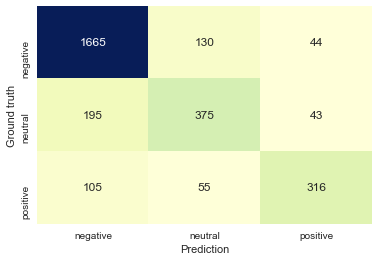

In [103]:
test_model(model, X_test, y_test)

### Interpreting what our model learnt

In [104]:
important = interpret(vectorizer, model)
important.sort_values(by='negative', ascending=False).head(10)

,negative,neutral,positive,word
4912,4.967290,-2.921389,-3.727240,worst
4128,2.946228,-0.443278,-1.887484,solution
879,2.897754,-1.602671,-0.588433,complaints
3801,2.772391,-2.236496,-0.567165,ridiculous
3850,2.632536,-0.956800,-2.500150,rude
162,2.611379,-0.989391,-0.756732,alternate
4627,2.523163,-1.931568,-0.431180,unacceptable
1996,2.505849,-0.948261,0.000000,hire
4911,2.504901,-1.586954,-0.439048,worse
1785,2.503553,-1.271211,-1.098440,fuck


In [105]:
important.sort_values(by='positive', ascending=False).head(10)

,negative,neutral,positive,word
4891,-3.174204,-0.596875,4.077104,wonderful
3447,-2.597946,0.000000,3.823447,props
1528,-2.084623,-1.372666,3.756503,excellent
1531,-2.139132,0.000000,3.637934,exceptional
2444,-2.299141,-0.505027,3.515789,kudos
4909,-3.360322,0.856123,3.473176,worries
4386,-2.771170,-1.163103,3.298997,thank
2618,-0.913667,-1.002182,3.110771,loving
4423,-0.453243,-2.052401,3.012763,thnx
2615,-0.180709,-1.732535,3.000078,loved


### Challenge

Use the `test_tweet` function below to test your classifier's performance on a list of tweets. Write your tweets 

In [108]:
def test_tweets(tweets, model):
    tweets = [clean(tweet) for tweet in tweets]
    features = vectorizer.transform(tweets)
    predictions = model.predict(features)
    return list(zip(tweets, predictions))

In [109]:
my_tweets = [example_tweet,
            'omg I am never flying on Delta again',
            'I love @VirginAmerica so much #friendlystaff']

test_tweets(my_tweets, model)

[('lol USER and USER are like soo HASHTAG HASHTAG saw it on URL HASHTAG',
  'neutral'),
 ('omg i am never flying on delta again', 'negative'),
 ('i love USER so much HASHTAG', 'positive')]

### Challenge

Use the `fit_random_forest` function below to train a random forest classifier on the training set and test the model on the test set. Which performs better?

In [106]:
def fit_random_forest(X_train, y_train):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    return model

Accuracy:  0.735655737704918


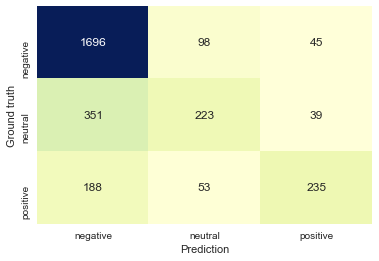

In [107]:
rf = fit_random_forest(X_train, y_train)
test_model(rf, X_test, y_test)

## Extra: Exploratory Data Analysis

Exploratory data analysis (EDA) is an important stage in any computational text analysis project. It's when we look closely at our data to understand it. We'd be interested in what each column holds, how individual values are distributed within each column. Normally, we would want to explore our dataset before we do any preprocessing or classification. For today's workshop though, we wanted to focus on the preprocessing and classification so we skipped the exploratory data analysis stage. The way I like to do EDA is to ask a series of questions about the dataset and then answer them. Unlike above, we'll work with the whole dataset as a pandas DataFrame.

In [110]:
fname = os.path.join(DATA_DIR, 'tweets.csv')
df = pd.read_csv(fname)
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


Which airlines are tweeted about and how many of each in this dataset?

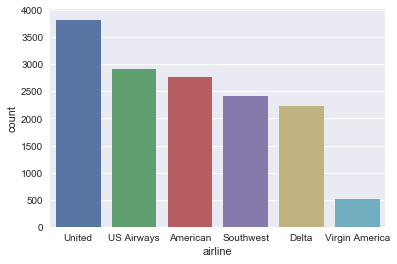

In [111]:
sns.countplot(df['airline'], order=df['airline'].value_counts().index);

### Challenge

- How many tweets are in the dataset?
- How many tweets are positive, neutral and negative?
- What **proportion** of tweets are positive, neutral and negative?
- Visualize these last two questions.

In [112]:
print("Length is", len(df))

Length is 14640


In [113]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [114]:
df['airline_sentiment'].value_counts(normalize=True)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

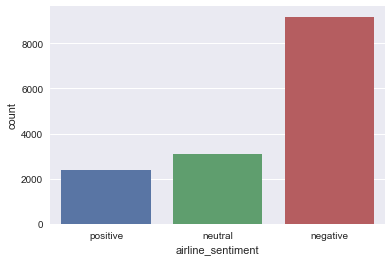

In [115]:
sns.countplot(df['airline_sentiment'], order=['positive', 'neutral', 'negative']);

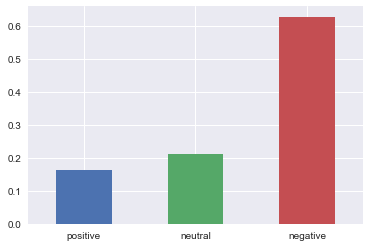

In [116]:
df['airline_sentiment'].value_counts(normalize=True, ascending=True).plot(kind='bar', rot=0);

### Extra challenge

- When did the tweets come from?
- Who gets more retweets: positive, negative or neutral tweets?
- What are the three main reasons why people are tweeting negatively? What could airline companies do to improve this?
- What's the distribution of time zones in which people are tweeting?
- Is this distribution consistent depending on what airlines they're tweeting about?

**All the tweets in this dataset came from the third week of February 2015.**

In [117]:
dates = pd.to_datetime(df['tweet_created'])
print("Year:\n")
print(dates.dt.year.value_counts())
print("Month:\n")
print(dates.dt.month.value_counts())
print("Day:\n")
print(dates.dt.day.value_counts())

Year:

2015    14640
Name: tweet_created, dtype: int64
Month:

2    14640
Name: tweet_created, dtype: int64
Day:

23    3515
22    2392
24    2136
20    1512
21    1418
18    1416
19    1298
17     953
Name: tweet_created, dtype: int64


We don't see any interesting evidence of tweets of different classes getting more or less retweets. The vast majority of tweets from all three classes get no retweets.

In [118]:
df.groupby('airline_sentiment')['retweet_count'].describe()

,count,mean,std,min,25%,50%,75%,max
airline_sentiment,,,,,,,,
negative,9178.0,0.093375,0.792865,0.0,0.0,0.0,0.0,44.0
neutral,3099.0,0.060987,0.658037,0.0,0.0,0.0,0.0,28.0
positive,2363.0,0.069403,0.659914,0.0,0.0,0.0,0.0,22.0


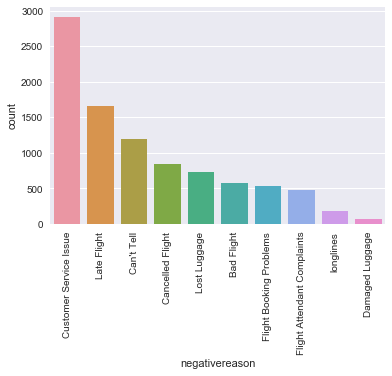

In [119]:
sns.countplot(df['negativereason'], order=df['negativereason'].value_counts().index)
plt.xticks(rotation=90);

What other questions might you like to know about this dataset?